In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
from matplotlib.ticker import FuncFormatter
sns.set()

In [2]:
import pyspark
from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.functions import count, avg

spark = SparkSession.builder.getOrCreate()

In [3]:
covid = pd.read_csv('new-york-history.csv')[['date', 'positive', 'positiveIncrease']]

# Adding data of March 1st
covid.loc[271] = ['2020-03-01', 0, 0]

# Convert string to date
covid['date'] = pd.to_datetime(covid['date']).dt.date

# Find data ranging from 2020-03-01 to 2020-06-30
start_date, end_date = date(2020, 3, 1), date(2020, 6, 30)
mask = (covid['date'] >= start_date) & (covid['date'] <= end_date)
covid = covid[mask].sort_values(by='date')
covid

,date,positive,positiveIncrease
271,2020-03-01,0,0
270,2020-03-02,0,0
269,2020-03-03,1,1
268,2020-03-04,1,0
267,2020-03-05,3,2
...,...,...,...
154,2020-06-26,391220,805
153,2020-06-27,391923,703
152,2020-06-28,392539,616
151,2020-06-29,392930,391


In [4]:
# Spark COVID-19 datafram from covid
scovid = spark.createDataFrame(covid)
scovid.show()

+----------+--------+----------------+
|      date|positive|positiveIncrease|
+----------+--------+----------------+
|2020-03-01|       0|               0|
|2020-03-02|       0|               0|
|2020-03-03|       1|               1|
|2020-03-04|       1|               0|
|2020-03-05|       3|               2|
|2020-03-06|      25|              22|
|2020-03-07|      36|              11|
|2020-03-08|      60|              24|
|2020-03-09|      88|              28|
|2020-03-10|     151|              63|
|2020-03-11|     195|              44|
|2020-03-12|     251|              56|
|2020-03-13|     353|             102|
|2020-03-14|     517|             164|
|2020-03-15|     648|             131|
|2020-03-16|     942|             294|
|2020-03-17|    1374|             432|
|2020-03-18|    2383|            1009|
|2020-03-19|    4152|            1769|
|2020-03-20|    7102|            2950|
+----------+--------+----------------+
only showing top 20 rows



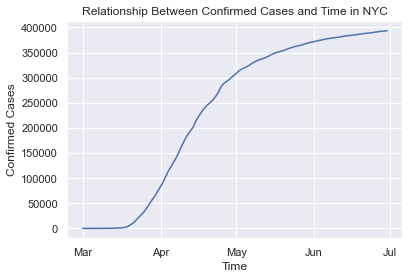

In [5]:
fig, ax = plt.subplots()
ax.plot(covid['date'], covid['positive'])

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((3, 4, 5, 6, 7)))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title('Relationship Between Confirmed Cases and Time in NYC')
plt.show()

In [6]:
# Function to union spark dataframes
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

## Flight Data

In [7]:
data_03 = (spark.read.format("csv").options(header="true")
    .load("flightlist_20200301_20200331.csv"))
data_04 = (spark.read.format("csv").options(header="true")
    .load("flightlist_20200401_20200430.csv"))
data_05 = (spark.read.format("csv").options(header="true")
    .load("flightlist_20200501_20200531.csv"))
data_06 = (spark.read.format("csv").options(header="true")
    .load("flightlist_20200601_20200630.csv"))

df = unionAll(data_03, data_04, data_05, data_06)

In [8]:
# Get data related to JFK Airport
df = df[(df['destination'] == 'KJFK') | (df['origin'] == 'KJFK')].select('day', 'origin', 'destination')

# Group by column 'day' and count number of flights, then transform date column
df = df.groupBy('day').count()
df = df.withColumn('date', (col('day').cast('date'))).select('date', 'count')

# Join with COVID dataframe
df = df.join(scovid, df['date'] == scovid['date']).select(df['date'], 'count', 'positive').orderBy('date')

In [9]:
df.show()

+----------+-----+--------+
|      date|count|positive|
+----------+-----+--------+
|2020-03-01| 1128|       0|
|2020-03-02| 1156|       0|
|2020-03-03| 1149|       1|
|2020-03-04| 1128|       1|
|2020-03-05| 1146|       3|
|2020-03-06| 1166|      25|
|2020-03-07| 1144|      36|
|2020-03-08| 1164|      60|
|2020-03-09| 1164|      88|
|2020-03-10| 1123|     151|
|2020-03-11| 1148|     195|
|2020-03-12| 1163|     251|
|2020-03-13| 1211|     353|
|2020-03-14| 1180|     517|
|2020-03-15| 1105|     648|
|2020-03-16| 1137|     942|
|2020-03-17| 1081|    1374|
|2020-03-18| 1044|    2383|
|2020-03-19| 1008|    4152|
|2020-03-20|  824|    7102|
+----------+-----+--------+
only showing top 20 rows



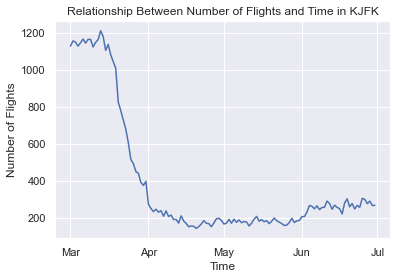

In [10]:
df = df.toPandas()

fig, ax = plt.subplots()
ax.plot(df['date'], df['count'])

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((3, 4, 5, 6, 7)))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
plt.xlabel('Time')
plt.ylabel('Number of Flights')
plt.title('Relationship Between Number of Flights and Time in KJFK')
plt.show()

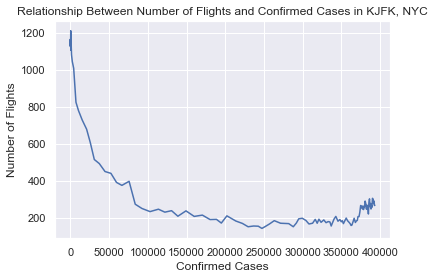

In [11]:
fig, ax = plt.subplots()
ax.plot(df['positive'], df['count'])
plt.xlabel('Confirmed Cases')
plt.ylabel('Number of Flights')
plt.title('Relationship Between Number of Flights and Confirmed Cases in KJFK, NYC')
plt.show()

## MTA Data

In [12]:
mta = pd.read_csv('MTA_recent_ridership_data_20201124.csv')
mta = mta[mta.columns[:2]]
mta.columns = ['Date', 'Total Ridership']

In [13]:
mta['weekday'] = pd.to_datetime(mta['Date']).dt.weekday
mta['date'] = pd.to_datetime(mta['Date']).dt.date
mta['month'] = pd.to_datetime(mta['Date']).dt.month

# Find data ranging from 2020-03-01 to 2020-06-30
start_date, end_date = date(2020, 3, 1), date(2020, 6, 30)
mask = (mta['date'] >= start_date) & (mta['date'] <= end_date)
mta = mta[mask].sort_values('date')

In [14]:
df = mta.join(covid.set_index('date'), on='date')
df.reset_index(drop=True, inplace=True)
df

,Date,Total Ridership,weekday,date,month,positive,positiveIncrease
0,3/1/2020,2214601,6,2020-03-01,3,0,0
1,3/2/2020,5347055,0,2020-03-02,3,0,0
2,3/3/2020,5498556,1,2020-03-03,3,1,1
3,3/4/2020,5515945,2,2020-03-04,3,1,0
4,3/5/2020,5513656,3,2020-03-05,3,3,2
...,...,...,...,...,...,...,...
117,6/26/2020,1104497,4,2020-06-26,6,391220,805
118,6/27/2020,616084,5,2020-06-27,6,391923,703
119,6/28/2020,536488,6,2020-06-28,6,392539,616
120,6/29/2020,1103086,0,2020-06-29,6,392930,391


In [15]:
df.to_csv('df.csv')

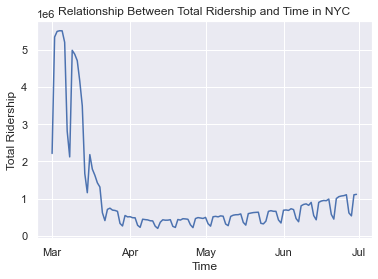

In [16]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['Total Ridership'])

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((3, 4, 5, 6, 7)))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
plt.xlabel('Time')
plt.ylabel('Total Ridership')
plt.title('Relationship Between Total Ridership and Time in NYC')
plt.show()

In [17]:
df_mw = df.groupby(['month', 'weekday']).agg({'Total Ridership': ['sum', 'count']})
df_mw['avg ridership'] = df_mw[('Total Ridership', 'sum')] / df_mw[('Total Ridership', 'count')]

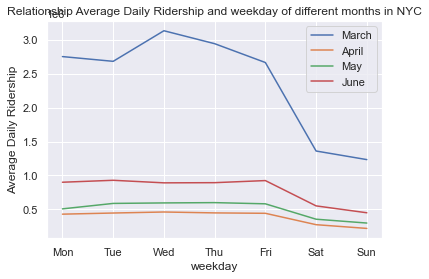

In [18]:
m = {3: 'March', 4: 'April', 5: 'May', 6: 'June'}
wd = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4:'Fri', 5: 'Sat', 6: 'Sun'}

fig, ax = plt.subplots()
for month, ndf in df_mw.groupby(level=0):
    ndf.reset_index(inplace=True)
    ax.plot(ndf['weekday'], ndf[('avg ridership', '')], label=m[month])

ax.xaxis.set_major_formatter(FuncFormatter(lambda d, _: wd[d] if d >= 0 and d <= 6 else d))
plt.xlabel('weekday')
plt.ylabel('Average Daily Ridership')
plt.title('Relationship Average Daily Ridership and weekday of different months in NYC')
ax.legend()

## Taxi Data

In [19]:
data_03 = (spark.read.format("csv").options(header="true")
    .load("yellow_tripdata_2020-03.csv"))
data_04 = (spark.read.format("csv").options(header="true")
    .load("yellow_tripdata_2020-04.csv"))
data_05 = (spark.read.format("csv").options(header="true")
    .load("yellow_tripdata_2020-05.csv"))
data_06 = (spark.read.format("csv").options(header="true")
    .load("yellow_tripdata_2020-06.csv"))

df = unionAll(data_03, data_04, data_05, data_06).select('tpep_pickup_datetime', 'passenger_count')

In [20]:
# Find data ranging from 2020-03-01 to 2020-06-30
df = df.withColumn('date', (col('tpep_pickup_datetime').cast('date')))
start_date, end_date = date(2020, 3, 1), date(2020, 6, 30)
mask = (df['date'] >= start_date) & (df['date'] <= end_date)
df = df[mask]

# Group by date and agg on date count and average passenger_count
df = df.groupBy('date').agg(count('date').alias('count'),
                            avg('passenger_count').alias('avg_cnt'))

# Join with COVID datafram
df = df.join(scovid, df['date'] == scovid['date']).select(df['date'], 'count', 'avg_cnt', 'positive').orderBy('date')

In [21]:
df.show()

+----------+------+------------------+--------+
|      date| count|           avg_cnt|positive|
+----------+------+------------------+--------+
|2020-03-01|179723|1.5568608100303354|       0|
|2020-03-02|193508|1.4624447947880015|       0|
|2020-03-03|222917|1.4571587814415892|       1|
|2020-03-04|229734|  1.44873874230257|       1|
|2020-03-05|244448|1.4573148094676314|       3|
|2020-03-06|243741|1.4863784736443633|      25|
|2020-03-07|208200|1.5691667149674453|      36|
|2020-03-08|165803|1.5493187645794124|      60|
|2020-03-09|175572|1.4560691642651298|      88|
|2020-03-10|184068|1.4513159415186014|     151|
|2020-03-11|182630| 1.446666962591413|     195|
|2020-03-12|171077|1.4393427263455016|     251|
|2020-03-13|134702| 1.456197710592286|     353|
|2020-03-14| 89650|1.5307900677200903|     517|
|2020-03-15| 59871|1.4961912356004954|     648|
|2020-03-16| 64201|1.3978963161591011|     942|
|2020-03-17| 45617|1.3688465684513116|    1374|
|2020-03-18| 36244| 1.357505171583213|  

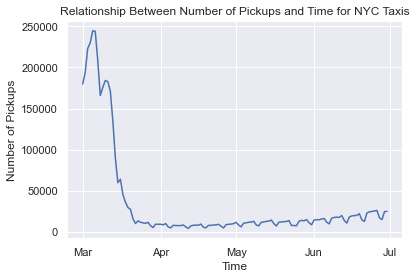

In [22]:
df = df.toPandas()

fig, ax = plt.subplots()
ax.plot(df['date'], df['count'])

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((3, 4, 5, 6, 7)))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
plt.xlabel('Time')
plt.ylabel('Number of Pickups')
plt.title('Relationship Between Number of Pickups and Time for NYC Taxis')
plt.show()

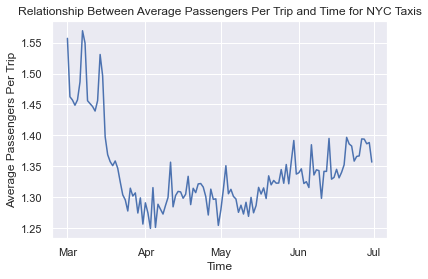

In [23]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['avg_cnt'])

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((3, 4, 5, 6, 7)))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
plt.xlabel('Time')
plt.ylabel('Average Passengers Per Trip')
plt.title('Relationship Between Average Passengers Per Trip and Time for NYC Taxis')
plt.show()

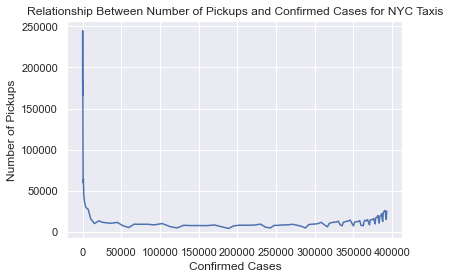

In [24]:
fig, ax = plt.subplots()
ax.plot(df['positive'], df['count'])
plt.xlabel('Confirmed Cases')
plt.ylabel('Number of Pickups')
plt.title('Relationship Between Number of Pickups and Confirmed Cases for NYC Taxis')
plt.show()